In [1]:
import pandas as pd
from plotnine import (
    aes,
    coord_cartesian,
    element_blank,
    element_line,
    element_text,
    facet_grid,
    facet_wrap,
    geom_line,
    geom_ribbon,
    geom_vline,
    ggplot,
    guide_legend,
    labs,
    scale_alpha_manual,
    scale_color_manual,
    scale_fill_manual,
    scale_linetype_manual,
    scale_x_date,
    theme,
    theme_bw,
    ylim,
)

from config import FORECAST_DATES, ROOT
from src.realtime_utils import load_target_series
from src.silence import silence_darts_warnings

silence_darts_warnings()

In [2]:
def increase_dates_by_weeks(dates, weeks):
    """
    Increases all dates in the list (except the last one) by a given number of weeks.
    """
    date_series = pd.to_datetime(dates)
    updated_dates = date_series[:-1] + pd.to_timedelta(weeks, unit="W")
    updated_dates = updated_dates[(updated_dates <= "2024-09-12") & (updated_dates != "2023-12-28")]
    updated_dates = updated_dates.tolist() + [date_series[-1]]

    return [date.strftime("%Y-%m-%d") for date in updated_dates]

In [3]:
def load_nowcast_wide(date, location="DE", age_group="00+"):
    file_path = ROOT / "nowcasts" / "simple_nowcast" / f"{date}-icosari-sari-simple_nowcast.csv"
    df = pd.read_csv(file_path)
    df_filtered = df[(df["location"] == location) & (df["age_group"] == age_group) & (df["type"] == "quantile")]

    df_wide = df_filtered.pivot(
        index=[
            "location",
            "age_group",
            "target_end_date",
            "forecast_date",
            "horizon",
        ],
        columns="quantile",
        values="value",
    )

    df_wide.columns = [f"quantile_{col}" for col in df_wide.columns]
    df_wide = df_wide.reset_index()

    return df_wide

In [4]:
def load_forecast_wide(date, model="ensemble", location="DE", age_group="00+"):
    file_path = ROOT / "forecasts" / model / f"{date}-icosari-sari-{model}.csv"
    df = pd.read_csv(file_path)
    df_filtered = df[(df["location"] == location) & (df["age_group"] == age_group) & (df["type"] == "quantile")]

    # Pivot the dataframe: quantile values will become columns with "quantile_" as a prefix
    df_wide = df_filtered.pivot(
        index=[
            "location",
            "age_group",
            "target_end_date",
            "forecast_date",
            "horizon",
        ],
        columns="quantile",
        values="value",
    )

    df_wide.columns = [f"quantile_{col}" for col in df_wide.columns]
    df_wide = df_wide.reset_index()

    return df_wide

# Plot multiple ensemble forecasts

In [5]:
model = "Ensemble"
age_group = "00+"
location = "DE"
ymax = 38000

In [6]:
DATES = [
    "2023-12-07",
    "2024-02-08",
    "2024-04-11",
    "2024-06-13",
    "2024-08-15",
    "2024-10-06",
]

df = pd.DataFrame()
df_nowcast = pd.DataFrame()
df_forecast = pd.DataFrame()
df_dates = pd.DataFrame()

for week_shift in range(1, 9):
    # print(week_shift)
    dates = increase_dates_by_weeks(DATES, week_shift)

    forecast_dates = dates[:-1]
    forecast_dates = [date for date in forecast_dates if date in FORECAST_DATES]  # to exclude Christmas

    df_dates_temp = pd.DataFrame({"forecast_date": forecast_dates, "shift": week_shift})
    df_dates = pd.concat([df_dates, df_dates_temp])

    dfs = []
    for f in dates:
        ts = load_target_series("sari", f, age_group=age_group)
        df_temp = ts.to_dataframe().reset_index()
        df_temp["forecast_date"] = f
        dfs.append(df_temp)

    df_temp = pd.concat(dfs)
    df_temp = df_temp.rename(columns={f"icosari-sari-{'DE' if age_group == '00+' else age_group}": "value"})
    df_temp["shift"] = week_shift
    df = pd.concat([df, df_temp])

    nowcasts = []
    for f in forecast_dates:
        df_temp = load_nowcast_wide(f, location, age_group)
        nowcasts.append(df_temp)
    df_nowcast_temp = pd.concat(nowcasts)
    df_nowcast_temp["shift"] = week_shift
    df_nowcast = pd.concat([df_nowcast, df_nowcast_temp])

    forecasts = []
    for f in forecast_dates:
        df_temp = load_forecast_wide(f, model, location, age_group)
        forecasts.append(df_temp)
    df_forecast_temp = pd.concat(forecasts)
    df_forecast_temp["shift"] = week_shift
    df_forecast = pd.concat([df_forecast, df_forecast_temp])

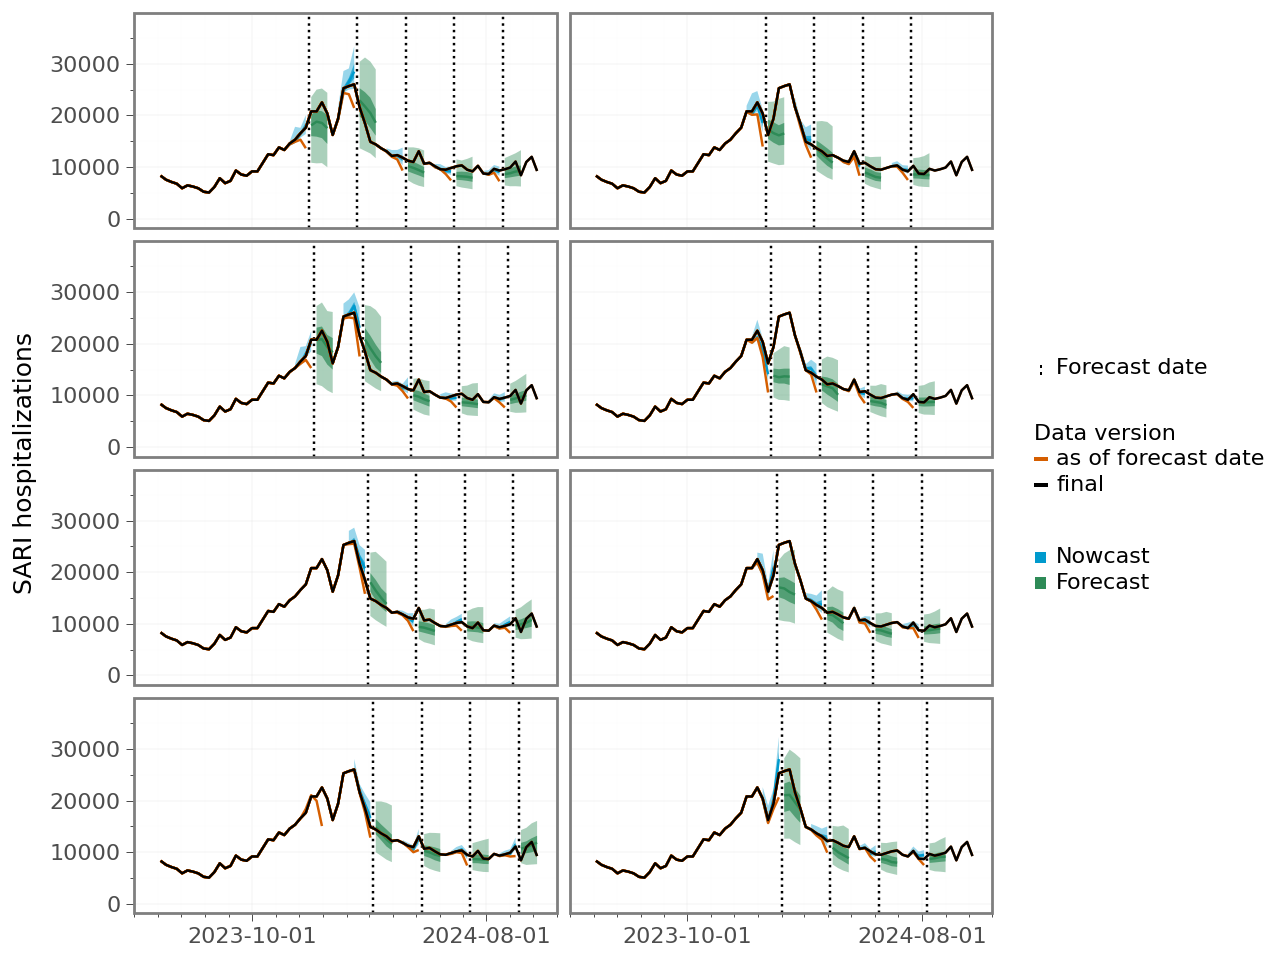

In [7]:
alphas = {"50%": 0.7, "95%": 0.4}

df = df[df.date >= "2023-06-01"]

p = (
    ggplot(df)
    + facet_wrap("shift", ncol=2, dir="v")
    + geom_vline(
        data=df_dates,
        mapping=aes(xintercept="forecast_date", linetype='"Forecast date"'),
        color="black",
    )
    + geom_ribbon(
        data=df_nowcast,
        mapping=aes(
            x="target_end_date",
            ymin="quantile_0.025",
            ymax="quantile_0.975",
            group="forecast_date",
            alpha='"95%"',
            fill='"Nowcast"',
        ),  # deepskyblue3
    )
    + geom_ribbon(
        data=df_nowcast,
        mapping=aes(
            x="target_end_date",
            ymin="quantile_0.25",
            ymax="quantile_0.75",
            group="forecast_date",
            alpha='"50%"',
            fill='"Nowcast"',
        ),
    )
    + geom_line(
        data=df_nowcast,
        mapping=aes(x="target_end_date", y="quantile_0.5", group="forecast_date"),
        color="#009ACD",
        linetype="solid",
    )
    + geom_ribbon(
        data=df_forecast,
        mapping=aes(
            x="target_end_date",
            ymin="quantile_0.025",
            ymax="quantile_0.975",
            group="forecast_date",
            alpha='"95%"',
            fill='"Forecast"',
        ),
    )
    + geom_ribbon(
        data=df_forecast,
        mapping=aes(
            x="target_end_date",
            ymin="quantile_0.25",
            ymax="quantile_0.75",
            group="forecast_date",
            alpha='"50%"',
            fill='"Forecast"',
        ),
    )
    + geom_line(
        data=df_forecast,
        mapping=aes(x="target_end_date", y="quantile_0.5", group="forecast_date"),
        color="seagreen",
        linetype="solid",
    )
    + geom_line(aes(x="date", y="value", group="forecast_date", color='"as of forecast date"'))
    + geom_line(
        data=df[df.forecast_date == "2024-10-06"],
        mapping=aes(x="date", y="value", color='"final"'),
    )
    + theme_bw()
    + labs(x="", y="SARI hospitalizations", linetype="")
    + scale_color_manual(
        name="\nData version",
        values={"as of forecast date": "#D55E00", "final": "black"},
    )
    + scale_fill_manual(name=" ", values={"Forecast": "seagreen", "Nowcast": "#009ACD"})
    + scale_linetype_manual(name=" ", values={"Forecast date": "dotted"}, guide=guide_legend(order=1))
    + scale_alpha_manual(name="Forecasts with \nprediction intervals:", values=alphas, guide=None)
    + scale_x_date(
        breaks=[pd.Timestamp("2023-10-01"), pd.Timestamp("2024-08-01")],
        date_minor_breaks="1 month",
    )
    + theme(
        legend_position="right",
        legend_title=element_text(size=8),
        legend_text=element_text(size=8),
        legend_key=element_blank(),
        legend_key_size=5,
        axis_title_y=element_text(size=9),
        axis_text=element_text(size=8),
        axis_ticks=element_line(color="black", size=0.25),
        panel_grid_major=element_line(size=0.15),
        panel_grid_minor=element_line(size=0.1),
        strip_background=element_blank(),
        strip_text=element_blank(),
    )
    + ylim(0, ymax)  # 35000
)

p.show()

In [8]:
p.save(
    ROOT / "figures" / "ensemble_forecasts.pdf",
    width=160,
    height=160,
    units="mm",
    dpi=300,
    verbose=False,
)

# Plot two panels

In [9]:
age_group = "00+"
location = "DE"
ymax = 35000

In [10]:
DATES = [
    "2023-12-07",
    "2024-02-08",
    "2024-04-11",
    "2024-06-13",
    "2024-08-15",
    "2024-10-06",
]

df = pd.DataFrame()
df_nowcast = pd.DataFrame()
df_forecast = pd.DataFrame()
df_dates = pd.DataFrame()

for week_shift in [0, 5]:
    dates = increase_dates_by_weeks(DATES, week_shift)
    forecast_dates = dates[:-1]
    df_dates_temp = pd.DataFrame({"forecast_date": forecast_dates, "shift": week_shift})
    df_dates = pd.concat([df_dates, df_dates_temp])

    dfs = []
    for f in dates:
        ts = load_target_series("sari", f, age_group=age_group)
        df_temp = ts.to_dataframe().reset_index()
        df_temp["forecast_date"] = f
        dfs.append(df_temp)

    df_temp = pd.concat(dfs)
    df_temp = df_temp.rename(columns={f"icosari-sari-{'DE' if age_group == '00+' else age_group}": "value"})
    df_temp["shift"] = week_shift
    df = pd.concat([df, df_temp])

    nowcasts = []
    for f in forecast_dates:
        df_temp = load_nowcast_wide(f, location, age_group)
        nowcasts.append(df_temp)
    df_nowcast_temp = pd.concat(nowcasts)
    df_nowcast_temp["shift"] = week_shift
    df_nowcast = pd.concat([df_nowcast, df_nowcast_temp])

    forecasts = []
    for f in forecast_dates:
        df_temp = load_forecast_wide(f, model, location, age_group)
        forecasts.append(df_temp)
    df_forecast_temp = pd.concat(forecasts)
    df_forecast_temp["shift"] = week_shift
    df_forecast = pd.concat([df_forecast, df_forecast_temp])

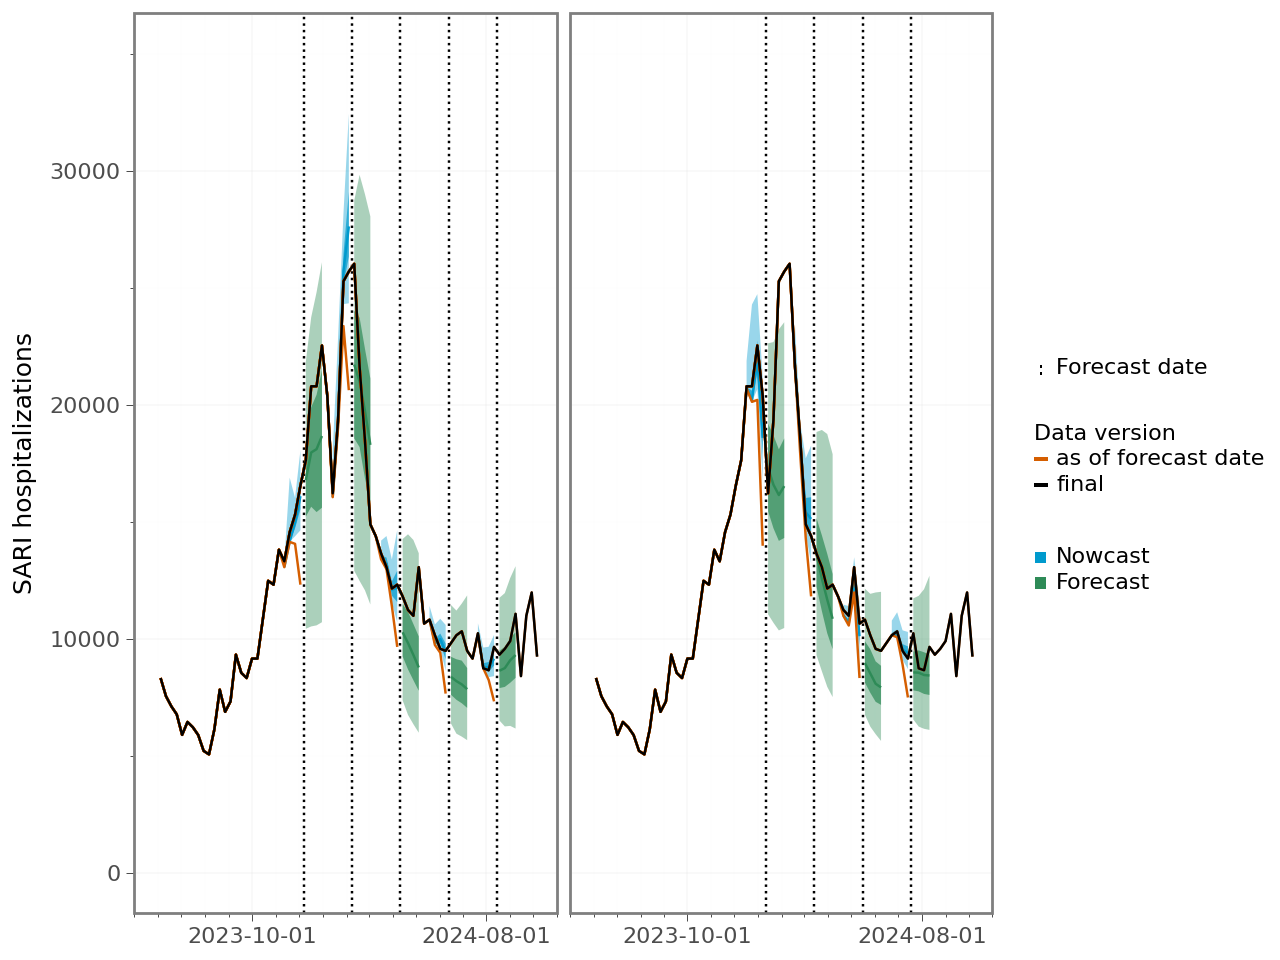

In [11]:
alphas = {"50%": 0.7, "95%": 0.4}

df = df[df.date >= "2023-06-01"]

p = (
    ggplot(df)
    + facet_wrap("shift", ncol=2, dir="v")
    + geom_vline(
        data=df_dates,
        mapping=aes(xintercept="forecast_date", linetype='"Forecast date"'),
        color="black",
    )
    + geom_ribbon(
        data=df_nowcast,
        mapping=aes(
            x="target_end_date",
            ymin="quantile_0.025",
            ymax="quantile_0.975",
            group="forecast_date",
            alpha='"95%"',
            fill='"Nowcast"',
        ),  # deepskyblue3
    )
    + geom_ribbon(
        data=df_nowcast,
        mapping=aes(
            x="target_end_date",
            ymin="quantile_0.25",
            ymax="quantile_0.75",
            group="forecast_date",
            alpha='"50%"',
            fill='"Nowcast"',
        ),
    )
    + geom_line(
        data=df_nowcast,
        mapping=aes(x="target_end_date", y="quantile_0.5", group="forecast_date"),
        color="#009ACD",
        linetype="solid",
    )
    + geom_ribbon(
        data=df_forecast,
        mapping=aes(
            x="target_end_date",
            ymin="quantile_0.025",
            ymax="quantile_0.975",
            group="forecast_date",
            alpha='"95%"',
            fill='"Forecast"',
        ),
    )
    + geom_ribbon(
        data=df_forecast,
        mapping=aes(
            x="target_end_date",
            ymin="quantile_0.25",
            ymax="quantile_0.75",
            group="forecast_date",
            alpha='"50%"',
            fill='"Forecast"',
        ),
    )
    + geom_line(
        data=df_forecast,
        mapping=aes(x="target_end_date", y="quantile_0.5", group="forecast_date"),
        color="seagreen",
        linetype="solid",
    )
    + geom_line(aes(x="date", y="value", group="forecast_date", color='"as of forecast date"'))
    + geom_line(
        data=df[df.forecast_date == "2024-10-06"],
        mapping=aes(x="date", y="value", color='"final"'),
    )
    + theme_bw()
    + labs(x="", y="SARI hospitalizations", linetype="")
    + scale_color_manual(
        name="\nData version",
        values={"as of forecast date": "#D55E00", "final": "black"},
    )
    + scale_fill_manual(name=" ", values={"Forecast": "seagreen", "Nowcast": "#009ACD"})
    + scale_linetype_manual(name=" ", values={"Forecast date": "dotted"}, guide=guide_legend(order=1))
    + scale_alpha_manual(name="Forecasts with \nprediction intervals:", values=alphas, guide=None)
    + scale_x_date(
        breaks=[pd.Timestamp("2023-10-01"), pd.Timestamp("2024-08-01")],
        date_minor_breaks="1 month",
    )
    + theme(
        legend_position="right",
        legend_title=element_text(size=8),
        legend_text=element_text(size=8),
        legend_key=element_blank(),
        legend_key_size=5,
        axis_title_y=element_text(size=9),
        axis_text=element_text(size=8),
        axis_ticks=element_line(color="black", size=0.25),
        panel_grid_major=element_line(size=0.15),
        panel_grid_minor=element_line(size=0.1),
        strip_background=element_blank(),
        strip_text=element_blank(),
    )
    + ylim(0, ymax)  # 35000
)

p.show()

In [12]:
p.save(
    ROOT / "figures" / "ensemble_forecasts2.pdf",
    width=160,
    height=55,
    units="mm",
    dpi=300,
    verbose=False,
)

# Multiple models and age groups

In [13]:
week_shift = 0
age_groups = ["00+", "15-34", "80+"]
location = "DE"

In [14]:
DATES = [
    "2023-12-07",
    "2024-02-08",
    "2024-04-11",
    "2024-06-13",
    "2024-08-15",
    "2024-10-06",
]
dates = increase_dates_by_weeks(DATES, week_shift)

forecast_dates = dates[:-1]

dfs = []
for age_group in age_groups:
    for f in dates:
        ts = load_target_series("sari", f, age_group=age_group)
        df = ts.to_dataframe().reset_index()
        df["forecast_date"] = f
        df["age_group"] = age_group
        df = df.rename(columns={f"icosari-sari-{'DE' if age_group == '00+' else age_group}": "value"})
        dfs.append(df)

df = pd.concat(dfs)

nowcasts = []
for age_group in age_groups:
    for f in forecast_dates:
        df_temp = load_nowcast_wide(f, location, age_group)
        nowcasts.append(df_temp)
df_nowcast = pd.concat(nowcasts)

In [15]:
models = ["ensemble", "hhh4-coupling", "lightgbm-coupling", "tsmixer-no_covariates-coupling"]

In [16]:
forecasts = []
for model in models:
    for age_group in age_groups:
        for f in forecast_dates:
            df_temp = load_forecast_wide(f, model, location, age_group)
            df_temp["model"] = model
            forecasts.append(df_temp)
df_forecast = pd.concat(forecasts)

In [17]:
df_forecast.model = df_forecast.model.replace(
    {
        "ensemble": "Ensemble",
        "hhh4-coupling": "hhh4",
        "lightgbm-coupling": "LightGBM",
        "tsmixer-no_covariates-coupling": "TSMixer",
    }
)

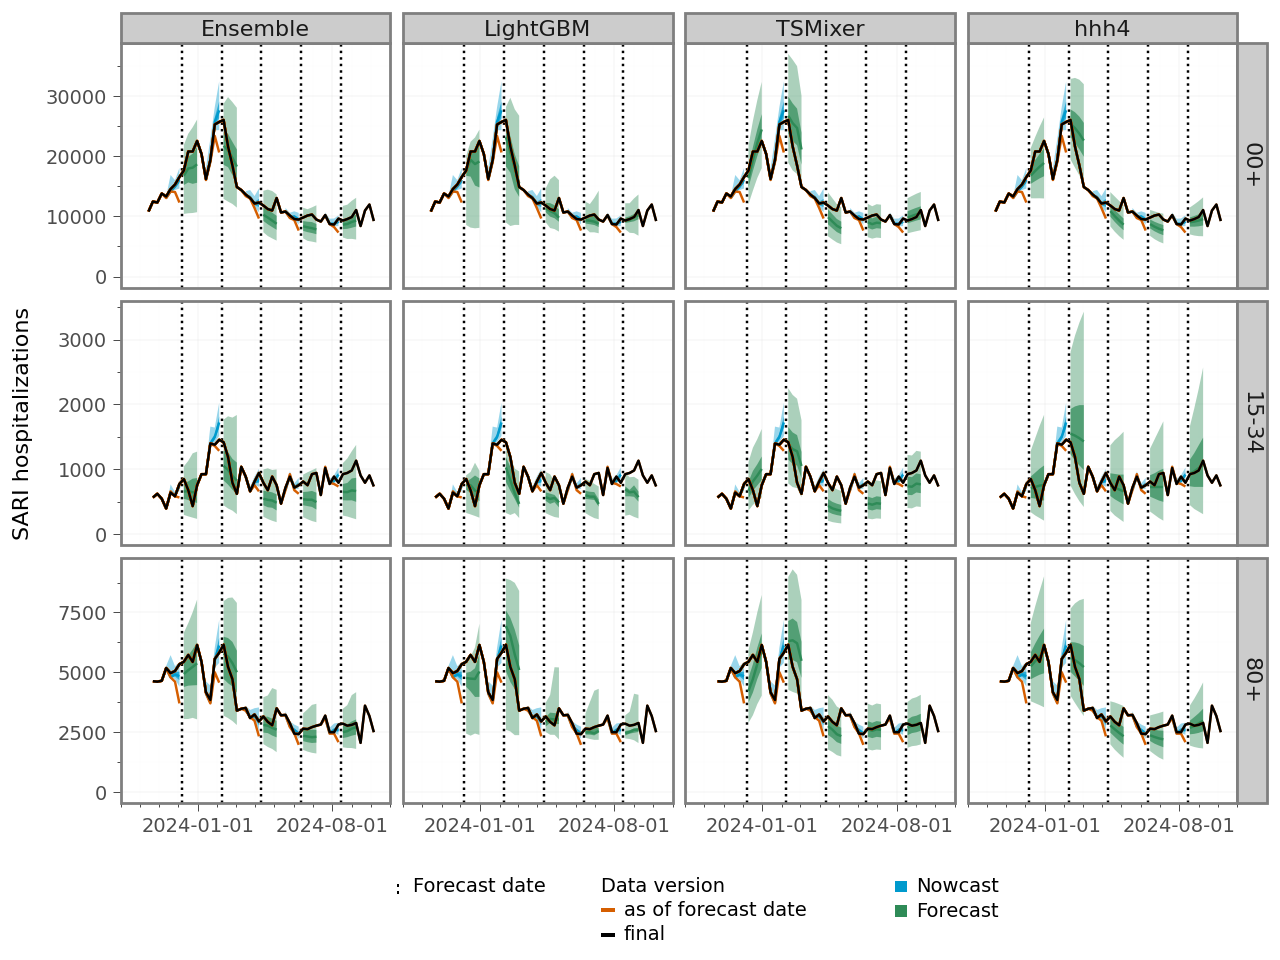

In [18]:
alphas = {"50%": 0.7, "95%": 0.4}

df = df[df.date >= "2023-10-14"]

p = (
    ggplot()
    + facet_grid(cols="model", rows="age_group", scales="free_y", drop=False)
    + geom_vline(
        data=pd.DataFrame({"date": [pd.Timestamp(f) for f in forecast_dates]}),
        mapping=aes(xintercept="date", linetype='"Forecast date"'),
        color="black",
    )
    + geom_ribbon(
        data=df_nowcast,
        mapping=aes(
            x="target_end_date",
            ymin="quantile_0.025",
            ymax="quantile_0.975",
            group="forecast_date",
            alpha='"95%"',
            fill='"Nowcast"',
        ),  # deepskyblue3
    )
    + geom_ribbon(
        data=df_nowcast,
        mapping=aes(
            x="target_end_date",
            ymin="quantile_0.25",
            ymax="quantile_0.75",
            group="forecast_date",
            alpha='"50%"',
            fill='"Nowcast"',
        ),
    )
    + geom_line(
        data=df_nowcast,
        mapping=aes(x="target_end_date", y="quantile_0.5", group="forecast_date"),
        color="#009ACD",
        linetype="solid",
    )
    + geom_ribbon(
        data=df_forecast,
        mapping=aes(
            x="target_end_date",
            ymin="quantile_0.025",
            ymax="quantile_0.975",
            group="forecast_date",
            alpha='"95%"',
            fill='"Forecast"',
        ),
    )
    + geom_ribbon(
        data=df_forecast,
        mapping=aes(
            x="target_end_date",
            ymin="quantile_0.25",
            ymax="quantile_0.75",
            group="forecast_date",
            alpha='"50%"',
            fill='"Forecast"',
        ),
    )
    + geom_line(
        data=df_forecast,
        mapping=aes(x="target_end_date", y="quantile_0.5", group="forecast_date"),
        color="seagreen",
        linetype="solid",
    )
    + geom_line(
        data=df,
        mapping=aes(x="date", y="value", group="forecast_date", color='"as of forecast date"'),
    )
    + geom_line(
        data=df[df.forecast_date == "2024-10-06"],
        mapping=aes(x="date", y="value", color='"final"'),
    )
    + theme_bw()
    + labs(x="", y="SARI hospitalizations", linetype="")
    + scale_color_manual(
        name="Data version",
        values={"as of forecast date": "#D55E00", "final": "black"},
        guide=guide_legend(order=2, nrow=2, direction="vertical"),
    )
    + scale_fill_manual(
        name=" ",
        values={"Forecast": "seagreen", "Nowcast": "#009ACD"},
        guide=guide_legend(order=3, nrow=2),
    )
    + scale_linetype_manual(name=" ", values={"Forecast date": "dotted"}, guide=guide_legend(order=1))
    + scale_alpha_manual(name="Forecasts with \nprediction intervals:", values=alphas, guide=None)
    + scale_x_date(
        breaks=[pd.Timestamp("2024-01-01"), pd.Timestamp("2024-08-01")],
        date_minor_breaks="1 month",
    )
    + theme(
        legend_position="bottom",
        legend_title=element_text(size=7),
        legend_text=element_text(size=7),
        legend_spacing=20,
        legend_key=element_blank(),
        legend_key_size=5,
        strip_text=element_text(size=8, margin={"t": 2, "b": 2, "l": 2, "r": 2}),
        axis_title_y=element_text(size=8),
        axis_text=element_text(size=7),
        axis_ticks=element_line(color="black", size=0.25),
        panel_grid_major=element_line(size=0.15),
        panel_grid_minor=element_line(size=0.1),
    )
    + coord_cartesian(ylim=(0, None))
)

p.show()

In [19]:
p.save(
    ROOT / "figures" / "forecasts_age_groups.pdf",
    width=165,
    height=100,
    units="mm",
    dpi=600,
    verbose=False,
)